# Identifying motifs using various CNN architectures

Try 3: Conv + conv + dense (two convolutional layers), still only using alt exon region

In [1]:
%matplotlib inline
from keras.models import Sequential, model_from_json
from keras.layers import Convolution1D, LSTM, GRU, Dense, Activation, Dropout, MaxPooling1D, Flatten, \
    GlobalAveragePooling1D, GlobalMaxPooling1D
from keras.objectives import binary_crossentropy, categorical_crossentropy
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping
from keras.preprocessing import sequence

import sys
import os
sys.path.append(os.path.abspath('../src/'))
import nn_utils
import keras_pooling
reload(nn_utils)
reload(keras_pooling)

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import r2_score
from sklearn.cross_validation import train_test_split

import tqdm
import cPickle

Using Theano backend.
/usr/local/lib/python2.7/dist-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Couldn't import dot_parser, loading of dot files will not be possible.


In [2]:
# loading data
X_train, X_test, Y_train, Y_test = nn_utils.load_a5_data()
Y2_test = Y_test[:,44]
Y2_train = Y_train[:,44]
X1_train = X_train.map(lambda x: x[0:25])
X1_test = X_test.map(lambda x: x[0:25])
#X1_train = X1_train.map(lambda x: np.rollaxis(x, 1))
#X1_test = X1_test.map(lambda x: np.rollaxis(x, 1))
X1_train = np.dstack(X1_train)
X1_train = np.rollaxis(X1_train, 2)
X1_test = np.dstack(X1_test)
X1_test = np.rollaxis(X1_test, 2)

Y2_train = Y2_train.reshape((len(Y2_train), 1))
Y2_test = Y2_test.reshape((len(Y2_test), 1))

In [3]:
num_filters = [200,64,32]
filter_length = [6,6,6]

# max pooling model
model1 = Sequential()
model1.add(Convolution1D(num_filters[0], filter_length[0], activation='relu', input_shape=(25,4)))
model1.add(MaxPooling1D(2))
model1.add(Convolution1D(num_filters[1], filter_length[1], activation='relu'))
model1.add(Flatten())
model1.add(Dense(output_dim=1, activation='linear'))
model1.add(Activation('sigmoid'))
model1.compile(loss='binary_crossentropy',
              optimizer='adam')


/usr/local/lib/python2.7/dist-packages/theano/tensor/signal/downsample.py:6: UserWarning: downsample module has been moved to the theano.tensor.signal.pool module.
  "downsample module has been moved to the theano.tensor.signal.pool module.")


In [4]:
early_stopping = EarlyStopping(monitor='val_loss', patience=2)

model1.fit(X1_train, Y2_train,
          nb_epoch=50,
          batch_size=500,
          show_accuracy=True,
          validation_data=(X1_test, Y2_test),
          callbacks=[early_stopping])

Train on 212035 samples, validate on 53009 samples
Epoch 1/50
212035/212035 [==============================] - 216s - loss: 0.5680 - val_loss: 0.5408
Epoch 2/50
212035/212035 [==============================] - 206s - loss: 0.5347 - val_loss: 0.5350
Epoch 3/50
212035/212035 [==============================] - 213s - loss: 0.5276 - val_loss: 0.5225
Epoch 4/50
212035/212035 [==============================] - 204s - loss: 0.5228 - val_loss: 0.5203
Epoch 5/50
212035/212035 [==============================] - 209s - loss: 0.5198 - val_loss: 0.5284
Epoch 6/50
212035/212035 [==============================] - 209s - loss: 0.5174 - val_loss: 0.5202
Epoch 7/50
212035/212035 [==============================] - 205s - loss: 0.5166 - val_loss: 0.5195
Epoch 8/50
212035/212035 [==============================] - 215s - loss: 0.5146 - val_loss: 0.5156
Epoch 9/50
212035/212035 [==============================] - 208s - loss: 0.5135 - val_loss: 0.5155
Epoch 10/50
212035/212035 [==============================]

/usr/local/lib/python2.7/dist-packages/keras/models.py:603: UserWarning: The "show_accuracy" argument is deprecated, instead you should pass the "accuracy" metric to the model at compile time:
`model.compile(optimizer, loss, metrics=["accuracy"])`
  warnings.warn('The "show_accuracy" argument is deprecated, '


In [5]:
predictions = model1.predict(X1_test)

In [6]:
r2_score(Y2_test, predictions)

0.60283148737433812

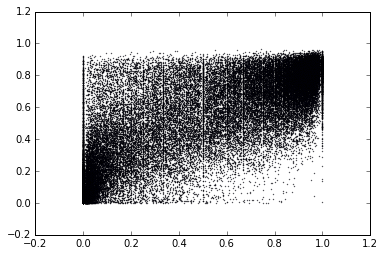

In [7]:
plt.scatter(Y2_test, predictions, s=0.1)

In [8]:
model1.save_weights('../data/2017-02-01.h5')
model_json = model1.to_json()
with open('../data/2017-02-01.json', 'w') as f:
    f.write(model_json)

In [9]:
import draw_logo
reload(draw_logo)

<module 'draw_logo' from '/home/yjzhang/Grad_School/research_notebooks/alternative_splicing_neural_nets/src/draw_logo.pyc'>

In [10]:
avg_filters = draw_logo.get_avg_filters(model1, X1_test)

In [11]:
avg_filters[0]

array([[ 0.19930954,  0.35443707,  0.11371868,  0.33253471],
       [ 0.63231965,  0.00647072,  0.04527618,  0.31593344],
       [ 0.35168276,  0.0046974 ,  0.01503547,  0.62858436],
       [ 0.02554331,  0.08155373,  0.0814594 ,  0.81144355],
       [ 0.05314292,  0.30925521,  0.07698838,  0.56061349],
       [ 0.5150166 ,  0.15542937,  0.1210006 ,  0.20855343]])

[<Container object of 6 artists>,
 <Container object of 6 artists>,
 <Container object of 6 artists>,
 <Container object of 6 artists>]

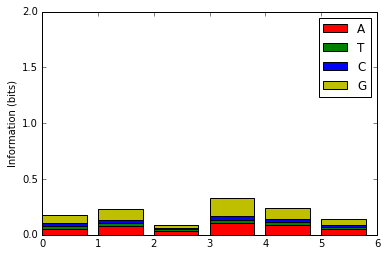

In [12]:
draw_logo.draw_logo(avg_filters[1], fixed_scale=True)

For this model, there's no way to get the "most effective" filters just by looking at the weights - because there are no global weights for each filter. Instead, the most effective filters might be the ones whose max output correlate most strongly with the final NN output? Or, use something like the "Influence score" from the Basset paper - nullify the filter's output, and then re-do the whole NN, and check the L2 norm of the differences in final output.

In [13]:
# find the 20 filters with the top information content, and plot them?
info = []
for i in range(200):
    info.append(6*2.0 - sum(draw_logo.entropy(avg_filters[i][j,:] for j in range(6))))
info_indices = list(sorted([(val, i) for i, val in enumerate(info) if not np.isnan(val)], reverse=True))
max_indices = [i[1] for i in info_indices[:20]]

## Maximum information content filters

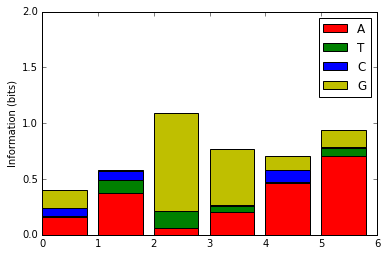

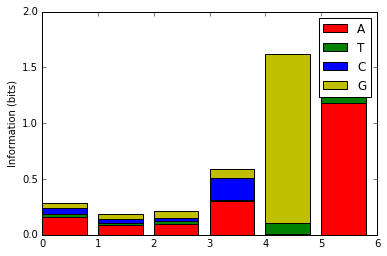

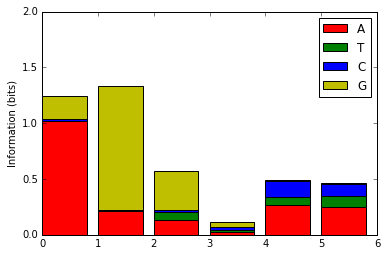

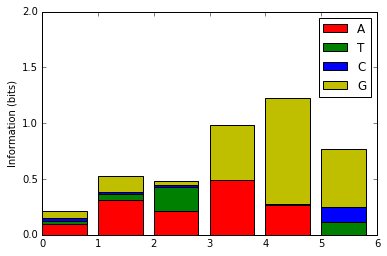

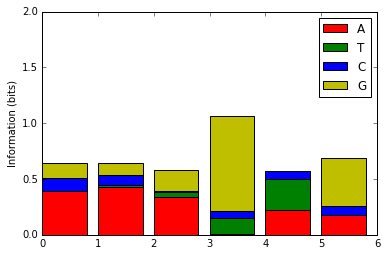

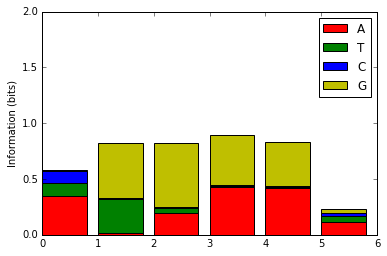

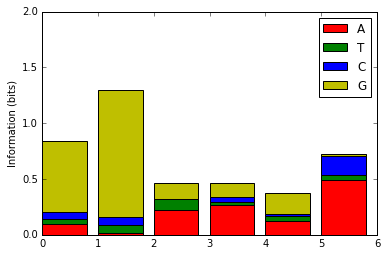

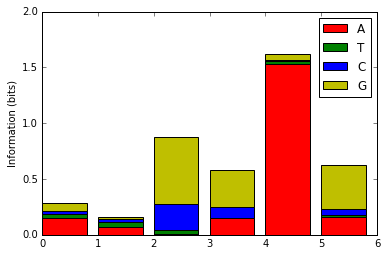

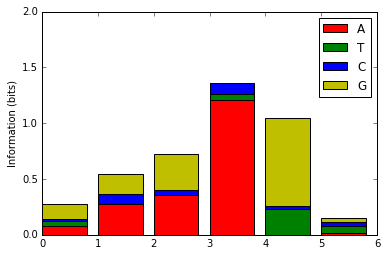

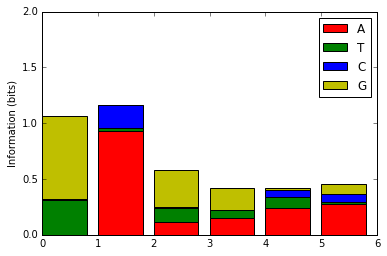

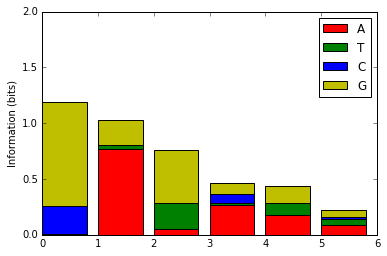

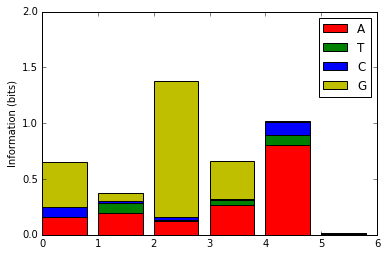

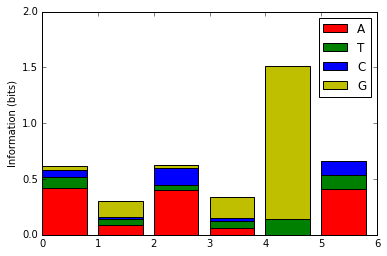

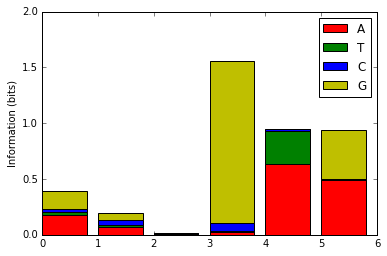

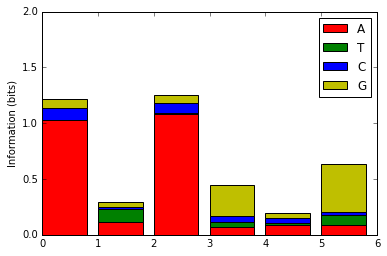

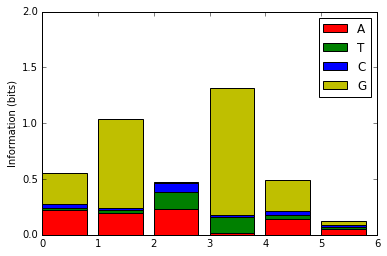

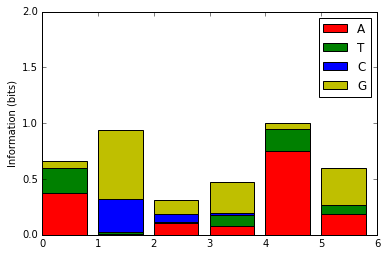

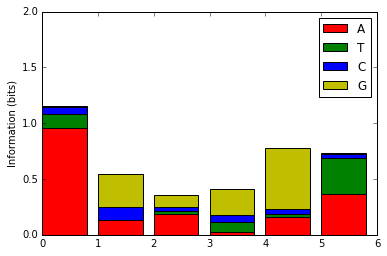

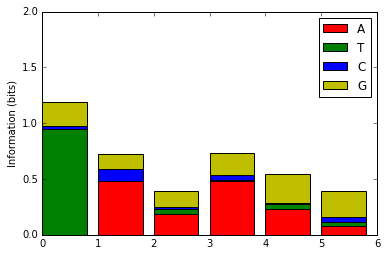

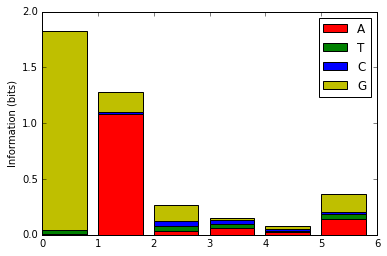

In [14]:
for index in max_indices:
    draw_logo.draw_logo(avg_filters[index], fixed_scale=True)

TODO: try another random initialization on the same data set and see if we get the same filters.

In [15]:
np.save('../data/2017-02-01-filters', avg_filters)

In [16]:
info_indices.sort(key=lambda x: x[0])

In [17]:
info_indices[:20]

[(0.82914367110387843, 44),
 (0.95380228410444801, 158),
 (1.2046655036427492, 1),
 (1.2405751170872374, 121),
 (1.3025958636925523, 76),
 (1.3665267005663431, 160),
 (1.5465947179406641, 139),
 (1.5596697607375152, 71),
 (1.6307762233956318, 190),
 (1.806586071326695, 85),
 (1.8310058922913832, 55),
 (1.8991291470771934, 19),
 (1.9173206582073625, 165),
 (1.9367979872302463, 101),
 (1.9450895967030686, 164),
 (1.9858019198150423, 119),
 (2.0089131814532202, 65),
 (2.1355432087065029, 142),
 (2.1457076111887954, 86),
 (2.24943769897029, 127)]